### Importacion de dependencias

In [13]:
import torch #nucleo de pytorch
import torch.optim as optim #importamos el modulo de optimizadores de pytorch
from torchvision import datasets, transforms # importamos datasets ya preparados.
import torch.nn as nn  #importamos el modulo de redes neuronales de pytorch
from torch.utils.data import DataLoader #Nos sirve para cargar los datos en porciones y hacer un barajado.

### Datasets.
Primero convertimos la imagen en un formato que PyTorch pueda entender: un tensor con valores entre 0 y 1. Luego, lo reescalamos para que esos valores estén entre -1 y 1, que es mejor para que la red aprenda. Es como decirle al modelo: ‘todo está centrado y balanceado, ahora aprendé’

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),                    # Convierte a tensor (0-1)
    transforms.Normalize((0.5,), (0.5,))     # Normaliza a (-1, 1)
])

### Cargar el dataset de entrenamiento FashionMNIST y el de test

In [15]:
train_dataset = datasets.FashionMNIST(
    root= "./data",
    train=True,
    download=True,
    transform=transform
)

#TODO: Carga el dataset de Test.
test_dataset = datasets.FashionMNIST(
    root= "./data",
    train=False,
    download=True,
    transform=transform
)

### Crea el DataLoader para entrenamiento: agrupa los datos en lotes (batch_size=8) y mezclalos con (shuffle=True)

In [16]:
#TODO: Crear el DataLoader para el set de train
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

### Crea  el DataLoader para test: lotes más grandes (1000 imágenes) y sin mezclar (shuffle=False)


In [17]:
#TODO: Crear el DataLoader para el set de test.
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

Creación del modelo MLP para procesamiento de imágenes.

Define el modelo MLP

Tamaño de capa Características

Pequeño (64, 128) Menor capacidad, más rápido, menos riesgo de overfitting
Mediano (256, 512) Más representativo, pero necesita más datos y regularización
Grande (1024+) Solo si tenés muchos datos

1. Toma una imagen de 28x28 → la aplana a 784.

2. La pasa por dos capas ocultas (128 y 64 neuronas).

3. Termina con una capa de salida de 10 neuronas (una por clase).

4. Usa una funcion de activacion para activar las capas ocultas.

In [18]:
class FashionMLP(nn.Module):
  def __init__(self):
    super(FashionMLP, self).__init__()
    self.flatter = nn.Flatten()
    self.net = nn.Sequential(
        #TODO: completar las capas ocultas y declarar una función de activacion
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)

    )
  def forward(self, x):
      x = self.flatter(x)
      return self.net(x)

Declaramos una variable llamada device para utilizarla posteriormente.
Declaramos la variable model que tendrá la clase MLP y le pasamos device para que utilice CUDA



In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionMLP().to(device)

Declaramos la funcion de perdida y el optimizador.

La función de pérdida nos dice qué tan mal se está comportando la red. Si el valor es alto, significa que la predicción está lejos de la clase correcta.

El optimizador define el algoritmo de optimización que ajustará los pesos del modelo. Usa el optimizador Adam, que es más avanzado que el clásico SGD. Como parametro le pasamos model.parameters() esto pasa todos los pesos entrenables del modelo. lr=0.001 es la tasa de aprendizaje (learning rate).

Learning rate: Es un número que controla cuánto cambian los pesos del modelo cada vez que actualizamos (cada batch o paso de entrenamiento).

In [20]:
#TODO: Declara la variable criterion y una función de perdida a utilizar.
criterion = nn.CrossEntropyLoss()
#TODO: Declara una variable optimizer y asignale un optimizador, por ejemplo: SGD
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Entrenamiento

Cuando creamos un modelo utilizando PyTorch, el entrenamiento lo hacemos de forma manual.

Declaramos las epochs (épocas) o interacciones que hará la red neuronal sobre nuestros datos.


In [21]:
#TODO: Crear el ciclo de entrenamiento correspondiente al modelo.

# Número de épocas
epochs = 10

# Listas para guardar métricas
loss_list = []
acc_list = []

print(f"Iniciando entrenamiento por {epochs} épocas...")
print(f"Usando dispositivo: {device}")

for epoch in range(epochs):
    # Estadísticas para esta época
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Poner el modelo en modo entrenamiento
    model.train()
    
    # Entrenar en todos los batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Mover datos al dispositivo (GPU/CPU)
        data, target = data.to(device), target.to(device)
        
        # Limpiar gradientes del optimizador
        optimizer.zero_grad()
        
        # Forward pass: calcular predicciones
        output = model(data)
        
        # Calcular la función de pérdida
        loss = criterion(output, target)
        
        # Backward pass: calcular gradientes
        loss.backward()
        
        # Actualizar pesos
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()
        
        # Mostrar progreso cada 1000 batches
        if batch_idx % 1000 == 0:
            print(f'Época {epoch+1}/{epochs}, Batch {batch_idx}, '
                  f'Loss: {loss.item():.4f}')
    
    # Calcular métricas de la época
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct_predictions / total_samples
    
    # Guardar métricas
    loss_list.append(epoch_loss)
    acc_list.append(epoch_accuracy)
    
    # Mostrar resumen de la época
    print(f'Época {epoch+1}/{epochs} completada:')
    print(f'  Loss promedio: {epoch_loss:.4f}')
    print(f'  Accuracy: {epoch_accuracy:.2f}%')
    print('-' * 50)

print("¡Entrenamiento completado!")

Iniciando entrenamiento por 10 épocas...
Usando dispositivo: cpu
Época 1/10, Batch 0, Loss: 2.3407
Época 1/10, Batch 1000, Loss: 0.4609
Época 1/10, Batch 1000, Loss: 0.4609
Época 1/10, Batch 2000, Loss: 1.9778
Época 1/10, Batch 2000, Loss: 1.9778
Época 1/10, Batch 3000, Loss: 0.2276
Época 1/10, Batch 3000, Loss: 0.2276
Época 1/10, Batch 4000, Loss: 0.6651
Época 1/10, Batch 4000, Loss: 0.6651
Época 1/10, Batch 5000, Loss: 0.8752
Época 1/10, Batch 5000, Loss: 0.8752
Época 1/10, Batch 6000, Loss: 0.0863
Época 1/10, Batch 6000, Loss: 0.0863
Época 1/10, Batch 7000, Loss: 0.1409
Época 1/10, Batch 7000, Loss: 0.1409
Época 1/10 completada:
  Loss promedio: 0.5088
  Accuracy: 81.28%
--------------------------------------------------
Época 2/10, Batch 0, Loss: 0.5656
Época 1/10 completada:
  Loss promedio: 0.5088
  Accuracy: 81.28%
--------------------------------------------------
Época 2/10, Batch 0, Loss: 0.5656
Época 2/10, Batch 1000, Loss: 0.4314
Época 2/10, Batch 1000, Loss: 0.4314
Época 2

### Grafico de la perdida y accuracy

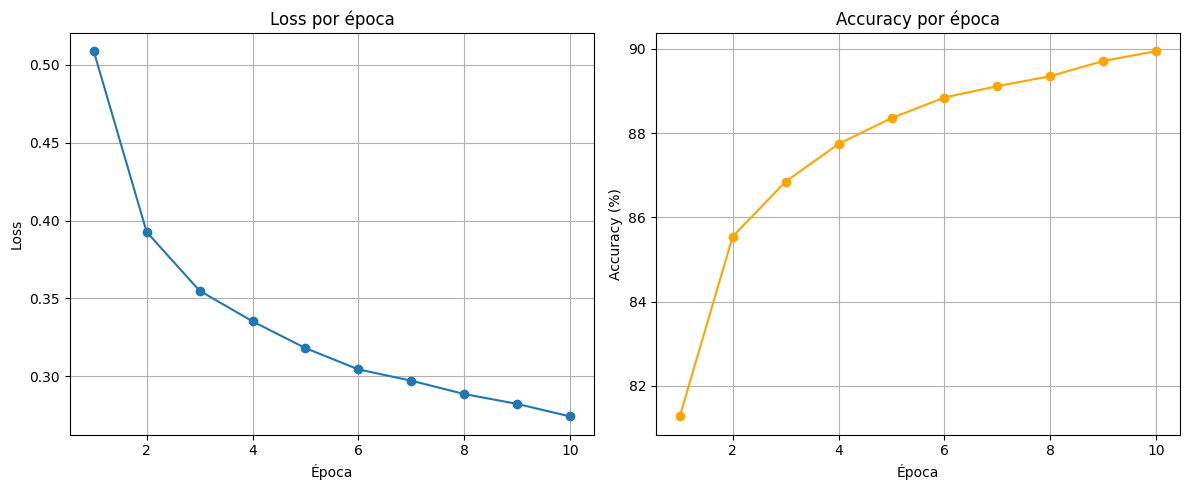

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))  # definimos el tamaño de la figura

# Pérdida
plt.subplot(1,2,1)                     # primera gráfica (izquierda)
plt.plot(range(1, epochs+1), loss_list, marker='o')  # graficamos loss por época
plt.title('Loss por época')            # título de la gráfica
plt.xlabel('Época')                    # etiqueta eje X
plt.ylabel('Loss')                     # etiqueta eje Y
plt.grid(True)                         # mostramos cuadrícula

# Accuracy
plt.subplot(1,2,2)                     # segunda gráfica (derecha)
plt.plot(range(1, epochs+1), acc_list, marker='o', color='orange')  # graficamos accuracy
plt.title('Accuracy por época')        # título de la gráfica
plt.xlabel('Época')                    # etiqueta eje X
plt.ylabel('Accuracy (%)')             # etiqueta eje Y
plt.grid(True)                         # mostramos cuadrícula

plt.tight_layout()                     # ajusta espaciado
plt.show()                             # mostramos la figura completa

MNIST FASHIONS posee clases para cada numero

    "Remera/Top",   # 0
    "Pantalón",     # 1
    "Suéter",       # 2
    "Vestido",      # 3
    "Abrigo",       # 4
    "Sandalia",     # 5
    "Camisa",       # 6
    "Zapatilla",    # 7
    "Bolso",        # 8
    "Botín"         # 9




In [23]:
class_names = [
    "Remera/Top",    # 0
    "Pantalón",     # 1
    "Suéter",       # 2
    "Vestido",      # 3
    "Abrigo",       # 4
    "Sandalia",     # 5
    "Camisa",       # 6
    "Zapatilla",    # 7
    "Bolso",        # 8
    "Botín"         # 9
]

### Prediccion

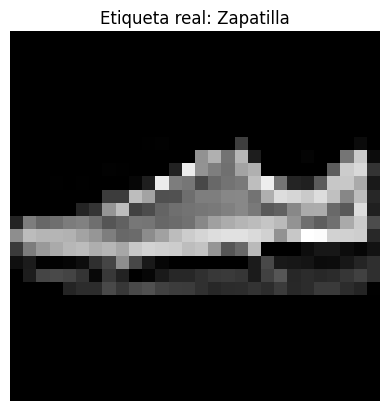

tensor([[-40.7788, -40.7417, -45.7826, -48.7770, -43.9218,   4.7322, -38.9700,
           8.3894, -11.7719,  -2.0183]])
tensor([7])
Predicción del modelo: Zapatilla


In [24]:
import matplotlib.pyplot as plt
i= 9
# Tomamos una sola imagen del test
images, labels = next(iter(test_loader))
image = images[i].to(device).unsqueeze(0)  # Agregamos dimensión de batch
label = labels[i]

# Mostramos la imagen en una escala de grises
plt.imshow(images[i].squeeze(), cmap='gray')
plt.title(f'Etiqueta real: {class_names[label]}')
plt.axis('off')
plt.show()

# ponemos el modelo en modo evaluacion
model.eval()
#hacemos la prediccion
with torch.no_grad():
    output = model(image)
    print(output)
    _, predicted = torch.max(output, 1)
    print(predicted)
    print(f'Predicción del modelo: {class_names[predicted.item()]}')